In [87]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder,MinMaxScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import KFold,StratifiedKFold,cross_val_score
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, log_loss
import xgboost as xgb
import lightgbm as lgb
import catboost as cat
import warnings
warnings.filterwarnings('ignore')

In [88]:
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("testA.csv")

### 数据预处理

In [89]:
numerical_feature = list(train_data.select_dtypes(exclude=['object']).columns)
category_feature = list(filter(lambda x : x not in numerical_feature,list(train_data.columns)))
label = "isDefault"
numerical_feature.remove(label)

In [90]:
# 补全缺失值 fillna()函数
train_data.isnull().sum()

id                        0
loanAmnt                  0
term                      0
interestRate              0
installment               0
grade                     0
subGrade                  0
employmentTitle           1
employmentLength      46799
homeOwnership             0
annualIncome              0
verificationStatus        0
issueDate                 0
isDefault                 0
purpose                   0
postCode                  1
regionCode                0
dti                     239
delinquency_2years        0
ficoRangeLow              0
ficoRangeHigh             0
openAcc                   0
pubRec                    0
pubRecBankruptcies      405
revolBal                  0
revolUtil               531
totalAcc                  0
initialListStatus         0
applicationType           0
earliesCreditLine         0
title                     1
policyCode                0
n0                    40270
n1                    40270
n2                    40270
n3                  

In [91]:
# 用中位数补充数值型变量
train_data[numerical_feature] = train_data[numerical_feature].fillna(train_data[numerical_feature].median())
test_data[numerical_feature] = test_data[numerical_feature].fillna(test_data[numerical_feature].median())
# 用众数补充分类型变量
train_data[category_feature] = train_data[category_feature].fillna(train_data[category_feature].mode())
test_data[category_feature] = test_data[category_feature].fillna(test_data[category_feature].mode())

In [92]:
train_data.isnull().sum()
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800000 entries, 0 to 799999
Data columns (total 47 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   id                  800000 non-null  int64  
 1   loanAmnt            800000 non-null  float64
 2   term                800000 non-null  int64  
 3   interestRate        800000 non-null  float64
 4   installment         800000 non-null  float64
 5   grade               800000 non-null  object 
 6   subGrade            800000 non-null  object 
 7   employmentTitle     800000 non-null  float64
 8   employmentLength    753201 non-null  object 
 9   homeOwnership       800000 non-null  int64  
 10  annualIncome        800000 non-null  float64
 11  verificationStatus  800000 non-null  int64  
 12  issueDate           800000 non-null  object 
 13  isDefault           800000 non-null  int64  
 14  purpose             800000 non-null  int64  
 15  postCode            800000 non-nul

In [93]:
# 对象类型的特征需要特殊处理 其中issueDate为时间类型
category_feature

['grade', 'subGrade', 'employmentLength', 'issueDate', 'earliesCreditLine']

In [94]:
for data in [train_data,test_data]:
    data['issueDate'] = pd.to_datetime(data['issueDate'],format="%Y-%m-%d")
    startDate = datetime.datetime.strptime("2020-1-01","%Y-%m-%d")
    data["issueDateDT"] = data['issueDate'].apply(lambda x: x-startDate).dt.days

In [95]:
train_data['employmentLength'].value_counts(dropna=False).sort_index()

1 year        52489
10+ years    262753
2 years       72358
3 years       64152
4 years       47985
5 years       50102
6 years       37254
7 years       35407
8 years       36192
9 years       30272
< 1 year      64237
NaN           46799
Name: employmentLength, dtype: int64

In [96]:
def employmentLength_to_int(s):
    if pd.isnull(s):
        return s
    else:
        return np.int8(s.split(" ")[0])

# 将对象类型转换为数值类型
for data in [train_data,test_data]:
    data['employmentLength'].replace(to_replace="10+ years",value="10 years",inplace=True)
    data['employmentLength'].replace(to_replace="< 1 year",value="0 years",inplace=True)
    data['employmentLength'] = data['employmentLength'].apply(employmentLength_to_int)

In [97]:
train_data['employmentLength'].value_counts().sort_index()

0.0      64237
1.0      52489
2.0      72358
3.0      64152
4.0      47985
5.0      50102
6.0      37254
7.0      35407
8.0      36192
9.0      30272
10.0    262753
Name: employmentLength, dtype: int64

In [98]:
train_data['earliesCreditLine'].value_counts().sort_index()

Apr-1955       2
Apr-1958       1
Apr-1960       2
Apr-1961       4
Apr-1962       4
            ... 
Sep-2011    1008
Sep-2012     575
Sep-2013     278
Sep-2014     104
Sep-2015       3
Name: earliesCreditLine, Length: 720, dtype: int64

In [99]:
for data in [train_data,test_data]:
    data['earliesCreditLine'] = data['earliesCreditLine'].apply(lambda s: int(s[-4:]))

In [100]:
data['earliesCreditLine'].sample(5)

28187     2004
104621    2001
48123     2005
42673     1997
89134     2001
Name: earliesCreditLine, dtype: int64

In [101]:
# 类别型特征处理
cate_features = ["grade","subGrade","employmentTitle","homeOwnership","verificationStatus",
                 "purpose","postCode","regionCode","applicationType","initialListStatus","title","policyCode"]

for f in cate_features:
    print(f"{f}特征，类别数目:{data[f].nunique()}")

grade特征，类别数目:7
subGrade特征，类别数目:35
employmentTitle特征，类别数目:79282
homeOwnership特征，类别数目:6
verificationStatus特征，类别数目:3
purpose特征，类别数目:14
postCode特征，类别数目:889
regionCode特征，类别数目:51
applicationType特征，类别数目:2
initialListStatus特征，类别数目:2
title特征，类别数目:12058
policyCode特征，类别数目:1


In [102]:
train_data["grade"].value_counts().sort_index()

A    139661
B    233690
C    227118
D    119453
E     55661
F     19053
G      5364
Name: grade, dtype: int64

In [103]:
# grade属于有大小关系的类别，可以使用labelCode或者直接自定义映射函数
for data in [train_data,test_data]:
    data["grade"] = data["grade"].map({"A":1,"B":2,"C":3,"D":4,"E":5,"F":6,"G":7})

In [104]:
train_data["grade"].value_counts().sort_index()

1    139661
2    233690
3    227118
4    119453
5     55661
6     19053
7      5364
Name: grade, dtype: int64

In [105]:
# 类型数大于2，并且不是高维稀疏的特征，可以直接编码
for data in [train_data,test_data]:
    data = pd.get_dummies(data,columns=["subGrade","homeOwnership","verificationStatus","purpose","regionCode"],drop_first=True)

#### 异常值处理

In [106]:
def filter_outliers_3segama(data,feature):
    data_std = np.std(data[feature])
    data_mean = np.mean(data[feature])
    cut_off = data_std * 3
    lower_bound = data_mean - cut_off
    upper_bound = data_mean + cut_off
    data[feature+"_outliers"] = data[feature].apply(lambda x:str("异常值") if x > upper_bound or x < lower_bound else "正常值")
    return data

In [107]:
for feature in numerical_feature:
    train_data = filter_outliers_3segama(train_data,feature)
    print(train_data[feature+"_outliers"].value_counts())
    print(train_data.groupby(feature+"_outliers")["isDefault"].sum())
    print("*"*10)

正常值    800000
Name: id_outliers, dtype: int64
id_outliers
正常值    159610
Name: isDefault, dtype: int64
**********
正常值    800000
Name: loanAmnt_outliers, dtype: int64
loanAmnt_outliers
正常值    159610
Name: isDefault, dtype: int64
**********
正常值    800000
Name: term_outliers, dtype: int64
term_outliers
正常值    159610
Name: isDefault, dtype: int64
**********
正常值    794259
异常值      5741
Name: interestRate_outliers, dtype: int64
interestRate_outliers
异常值      2916
正常值    156694
Name: isDefault, dtype: int64
**********
正常值    792046
异常值      7954
Name: installment_outliers, dtype: int64
installment_outliers
异常值      2152
正常值    157458
Name: isDefault, dtype: int64
**********
正常值    800000
Name: employmentTitle_outliers, dtype: int64
employmentTitle_outliers
正常值    159610
Name: isDefault, dtype: int64
**********
正常值    799701
异常值       299
Name: homeOwnership_outliers, dtype: int64
homeOwnership_outliers
异常值        62
正常值    159548
Name: isDefault, dtype: int64
**********
正常值    793973
异常值      

In [108]:
# 删除异常值
for feature in numerical_feature:
    train_data = train_data[train_data[feature+"_outliers"]=="正常值"]
    train_data = train_data.reset_index(drop=True)

In [109]:
train_data[numerical_feature].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 612742 entries, 0 to 612741
Data columns (total 41 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   id                  612742 non-null  int64  
 1   loanAmnt            612742 non-null  float64
 2   term                612742 non-null  int64  
 3   interestRate        612742 non-null  float64
 4   installment         612742 non-null  float64
 5   employmentTitle     612742 non-null  float64
 6   homeOwnership       612742 non-null  int64  
 7   annualIncome        612742 non-null  float64
 8   verificationStatus  612742 non-null  int64  
 9   purpose             612742 non-null  int64  
 10  postCode            612742 non-null  float64
 11  regionCode          612742 non-null  int64  
 12  dti                 612742 non-null  float64
 13  delinquency_2years  612742 non-null  float64
 14  ficoRangeLow        612742 non-null  float64
 15  ficoRangeHigh       612742 non-nul

#### 数据分箱

In [27]:
# 固定宽度分箱 按照10的幂次来分箱
train_data["loanAmnt_bin1"] = np.floor_divide(data["loanAmnt"],1000)
train_data["loanAmnt_bin1"]

0         14.0
1         20.0
2         12.0
3         17.0
4         35.0
          ... 
612737     NaN
612738     NaN
612739     NaN
612740     NaN
612741     NaN
Name: loanAmnt_bin1, Length: 612742, dtype: float64

In [28]:
# 通过对数函数映射到指数宽度分箱
train_data["loanAmnt_bin2"] = np.floor(np.log10(data["loanAmnt"]))
train_data["loanAmnt_bin2"]

0         4.0
1         4.0
2         4.0
3         4.0
4         4.0
         ... 
612737    NaN
612738    NaN
612739    NaN
612740    NaN
612741    NaN
Name: loanAmnt_bin2, Length: 612742, dtype: float64

In [30]:
# 分位数分箱
train_data["loanAmnt_bin3"] = pd.qcut(data["loanAmnt"],10,labels=False)
train_data["loanAmnt_bin3"]

0         5.0
1         7.0
2         4.0
3         6.0
4         9.0
         ... 
612737    NaN
612738    NaN
612739    NaN
612740    NaN
612741    NaN
Name: loanAmnt_bin3, Length: 612742, dtype: float64

#### 特征交互

In [33]:
for col in ['grade','subGrade']:
    temp_dict = train_data.groupby([col])['isDefault'].agg(['mean']).reset_index().rename(columns={"mean": col+"_target_mean"})
    temp_dict.index = temp_dict[col].values
    temp_dict = temp_dict[col+"_target_mean"].to_dict()

    train_data[col + "_target_mean"] = train_data[col].map(temp_dict)
    test_data[col + "_target_mean"] = test_data[col].map(temp_dict)

In [36]:
# 基于mean和std的衍生特征
for df in [train_data,test_data]:
    for item in ["n0","n1","n2","n3","n4","n5","n6","n7","n8","n9","n10","n11","n12","n13","n14"]:
        df["grade_to_mean_" + item] = df["grade"] / df.groupby([item])['grade'].transform("mean")
        df["grade_to_std_" + item] = df["grade"] / df.groupby([item])['grade'].transform("std")

In [37]:
train_data.columns

Index(['id', 'loanAmnt', 'term', 'interestRate', 'installment', 'grade',
       'subGrade', 'employmentTitle', 'employmentLength', 'homeOwnership',
       ...
       'grade_to_mean_n10', 'grade_to_std_n10', 'grade_to_mean_n11',
       'grade_to_std_n11', 'grade_to_mean_n12', 'grade_to_std_n12',
       'grade_to_mean_n13', 'grade_to_std_n13', 'grade_to_mean_n14',
       'grade_to_std_n14'],
      dtype='object', length=124)

In [38]:
print(train_data.shape)

(612742, 124)


#### 特征编码

In [110]:
# 对subGrade、postGrade和title这种高维特征进行转化
for col in tqdm(['employmentTitle','postCode','title','subGrade']):
    le = LabelEncoder()
    le.fit(list(train_data[col].astype(str).values) + list(test_data[col].astype(str).values))
    train_data[col] = le.transform(list(train_data[col].astype(str).values))
    test_data[col] = le.transform(list(test_data[col].astype(str).values))
print("Label Encoding编码完成")

100%|██████████| 4/4 [00:05<00:00,  1.46s/it]

Label Encoding编码完成


某些模型需要归一化处理 比如逻辑回归，树模型不需要归一化处理
去除一些有高相关性的特征

#### 特征选择
*删除无效特征，对缺失值进行补全，然后计算以下协方差看一下特征之间的相关性，最后进行模型训练，得到一个baseline*

In [111]:
for data in [train_data,test_data]:
    data.drop(['issueDate','id'],axis=1,inplace=True)

In [112]:
train_data = train_data.fillna(axis=0,method='ffill')

In [113]:
x_train = train_data.drop(['isDefault'],axis=1)
# 计算协方差
data_corr = x_train.corrwith(train_data['isDefault'])
result = pd.DataFrame(columns=['features','corr'])
result['features'] = data_corr.index
result['corr'] = data_corr.values
result

,features,corr
0,loanAmnt,0.061056
1,term,0.174659
2,interestRate,0.254421
3,installment,0.043117
4,grade,0.256237
5,subGrade,0.262355
6,employmentTitle,0.012089
7,employmentLength,-0.013105
8,homeOwnership,0.053502
9,annualIncome,-0.065541


<Axes: title={'center': 'Correlation of numberical features'}>

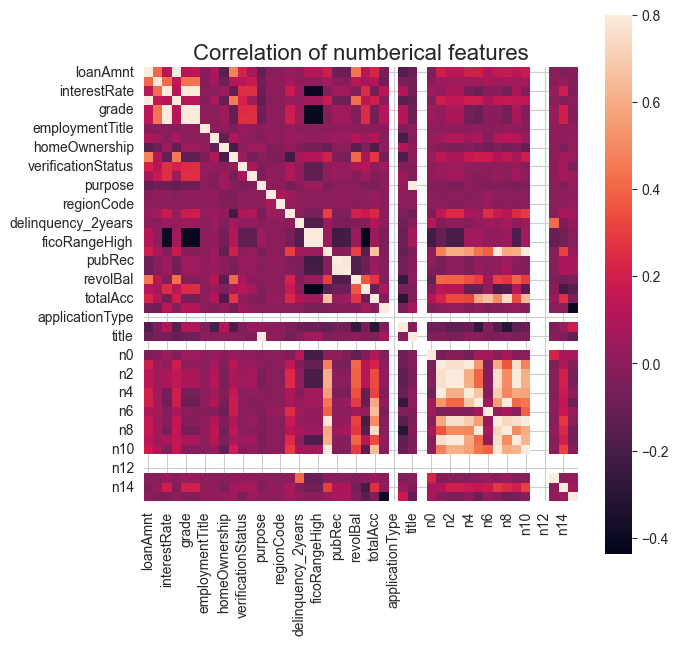

In [114]:
# 画热力图
numerical_feature = list(train_data.select_dtypes(exclude=['object']).columns)
data_numerical = train_data[numerical_feature]
correlation = data_numerical.corr()
fg,ax = plt.subplots(figsize=(7,7))
plt.title("Correlation of numberical features", y=1, size=16)
sns.heatmap(correlation,square=True, vmax=0.8)

In [115]:
features = [f for f in train_data.columns if f not in ['id','issueDate','isDefault'] and '_outliers' not in f]
x_train = train_data[features]
x_test = train_data[features]
y_train = train_data['isDefault']

In [142]:
def cv_model(clf,train_x,train_y,test_x,clf_name):
    folds = 5
    seed = 2023
    kf = KFold(n_splits=folds,shuffle=True,random_state=seed)

    train = np.zeros(train_x.shape[0])
    test = np.zeros(test_x.shape[0])
    cv_scores = []

    # 拆分数据集进行训练
    for i, (train_index,valid_index) in enumerate(kf.split(train_x,train_y)):
        print(f"***********************第{str(i+1)}折训练")
        # 分割数据集
        train_feature,train_label,valid_feature,valid_label = train_x.iloc[train_index], train_y.iloc[train_index], train_x.iloc[valid_index], train_y.iloc[valid_index]

        if clf_name == "lgb":
            # lightGBM的模型输入数据必须转换成这种形式
            train_matrix = clf.Dataset(train_feature,train_label)
            valid_matrix = clf.Dataset(valid_feature,valid_label)

            # 这里写死参数，后面阶段在进行调参
            params = {
                'boosting_type': 'gbdt',
                'objective': 'binary',
                'metric': 'auc',
                'min_child_weight': 5,
                'num_leaves': 2 ** 5,
                'lambda_l2': 10,
                'feature_fraction': 0.8,
                'bagging_fraction': 0.8,
                'bagging_freq': 4,
                'learning_rate': 0.1,
                'seed': 2020,
                'nthread': 28,
                'n_jobs':24,
                'verbose': -1,
            }

            model = clf.train(params,train_matrix,50000,valid_sets=[train_matrix,valid_matrix],
                              verbose_eval=200,early_stopping_rounds=200)
            valid_pred = model.predict(valid_feature,num_iteration=model.best_iteration)
            # 测试集预测
            test_pred = model.predict(test_x,num_iteration=model.best_iteration)

        if clf_name == "xgb":
            train_matrix = clf.DMatrix(train_feature,label=train_label)
            valid_matrix = clf.DMatrix(valid_feature,label=valid_label)

            params = {'booster': 'gbtree',
                      'objective': 'binary:logistic',
                      'eval_metric': 'auc',
                      'gamma': 1,
                      'min_child_weight': 1.5,
                      'max_depth': 5,
                      'lambda': 10,
                      'subsample': 0.7,
                      'colsample_bytree': 0.7,
                      'colsample_bylevel': 0.7,
                      'eta': 0.04,
                      'tree_method': 'exact',
                      'seed': 2020,
                      'nthread': 36,
                      }

            watch_list = [(train_matrix,"train"),(valid_matrix,'eval')]

            model = clf.train(params,train_matrix,num_boost_round=50000,evals=watch_list,
                              verbose_eval=200,early_stopping_rounds=200)
            valid_pred = model.predict(valid_matrix,ntree_limit=model.best_ntree_limit)
            # 测试集预测
            test_pred = model.predict(test_x,ntree_limit=model.best_ntree_limit)

        if clf_name == "cat":

            param = {'learning_rate': 0.05,
                      'depth': 5,
                      'l2_leaf_reg': 10,
                      'bootstrap_type': 'Bernoulli',
                      'od_type': 'Iter',
                      'od_wait': 50,
                      'random_seed': 11,
                      'allow_writing_files': False}

            watch_list = [(train_matrix,"train"),(valid_matrix,'eval')]
            model = clf.train(params=params,dtrain=train_matrix,num_boost_round=50000,evals=watch_list,
                              verbose_eval=200,early_stopping_rounds=200)

            valid_pred = model.predict(valid_feature)
            test_pred = model.predict(test_x)

        # 保存结果
        train[valid_index] = valid_pred
        test = test_pred / kf.n_splits
        cv_scores.append(roc_auc_score(valid_label,valid_pred))

        print(cv_scores)

    print(f"{clf_name} score_list:{cv_scores}")
    print(f"{clf_name} score_mean:{np.mean(cv_scores)}")
    print(f"{clf_name} score_std:{np.std(cv_scores)}")
    return train,test

In [143]:
# LightGBM模型
def lgb_model(train_x,train_y,test_x):
    lgb_train,lgb_test = cv_model(lgb,train_x,train_y,test_x,"lgb")
    return lgb_train,lgb_test

# XgBoost模型
def xgb_model(train_x,train_y,test_x):
    xgb_train,xgb_test = cv_model(xgb,train_x,train_y,test_x,"xgb")
    return xgb_train,xgb_test

# CatBoost模型
def cat_model(train_x,train_y,test_x):
    cat_train,cat_test = cv_model(cat,train_x,train_y,test_x,'cat')
    return cat_test,cat_test

In [119]:
lgb_train, lgb_test = lgb_model(x_train,y_train,x_test)

***********************第1折训练
[LightGBM] [Warning] num_threads is set with nthread=28, will be overridden by n_jobs=24. Current value: num_threads=24
[LightGBM] [Warning] Unknown parameter: silent
Training until validation scores don't improve for 200 rounds
[200]	training's auc: 0.748665	valid_1's auc: 0.729976
[400]	training's auc: 0.763796	valid_1's auc: 0.730954
[600]	training's auc: 0.776608	valid_1's auc: 0.731378
[800]	training's auc: 0.78896	valid_1's auc: 0.730733
Early stopping, best iteration is:
[635]	training's auc: 0.778844	valid_1's auc: 0.731505
[0.7315050893159135]
***********************第2折训练
[LightGBM] [Warning] num_threads is set with nthread=28, will be overridden by n_jobs=24. Current value: num_threads=24
[LightGBM] [Warning] Unknown parameter: silent
Training until validation scores don't improve for 200 rounds
[200]	training's auc: 0.748676	valid_1's auc: 0.729722
[400]	training's auc: 0.76418	valid_1's auc: 0.730763
[600]	training's auc: 0.777555	valid_1's auc:

In [144]:
cat_train, cat_test = xgb_model(x_train,y_train,x_test)

***********************第1折训练
[0]	train-auc:0.69601	eval-auc:0.69204
[200]	train-auc:0.73115	eval-auc:0.72396
[400]	train-auc:0.74003	eval-auc:0.72841
[600]	train-auc:0.74607	eval-auc:0.73037
[800]	train-auc:0.75091	eval-auc:0.73136
[1000]	train-auc:0.75549	eval-auc:0.73199
[1200]	train-auc:0.75978	eval-auc:0.73246
[1400]	train-auc:0.76365	eval-auc:0.73273
[1600]	train-auc:0.76730	eval-auc:0.73283
[1800]	train-auc:0.77068	eval-auc:0.73301
[2000]	train-auc:0.77415	eval-auc:0.73307
[2200]	train-auc:0.77745	eval-auc:0.73307
[2358]	train-auc:0.77992	eval-auc:0.73299


TypeError: ('Expecting data to be a DMatrix object, got: ', <class 'pandas.core.frame.DataFrame'>)